# Evalution of Replicate Agreement
In this notebook, I want to explore how well the replicates of the dual RNA-seq experiements agree with one another.
For that purpose, I'll load three different runs of the GCN for the three different replicates.
Then, I'll see how much they have in common.

In [1]:
import numpy as np
import pandas as pd
import h5py, os

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn

from statsmodels.stats.inter_rater import fleiss_kappa, cohens_kappa
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Loading GCN Predictions

In [3]:
model_dir_rep1 = '../data/GCN/training/legionella_rep1_cv5_good/'
model_dir_rep2 = '../data/GCN/training/legionella_rep2_cv5_good/'
model_dir_rep3 = '../data/GCN/training/legionella_rep3_cv5_good/'
data_file = '../data/preprocessing/legionella_gcn_input_unbalanced.h5'
CLASSIFICATION_THRESHOLD = 0.5

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

# get a label dataframe
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'name']).drop('ID', axis=1)
labels_df['label'] = (y_train[:,0] | y_test[:,0])
labels_df['train_label'] = y_train[:, 0]
labels_df['test_label'] = y_test[:, 0]


def prediction_stats(predictions, labels_df):
    labels_with_pred = labels_df.join(predictions)
    predictions_for_knowns = labels_with_pred[labels_with_pred.label == 1]
    pos_pred = predictions_for_knowns[predictions_for_knowns.Prob_pos > CLASSIFICATION_THRESHOLD]
    known_pos_predictions = pos_pred.shape[0]
    number_of_knowns = predictions_for_knowns.shape[0]
    pred_test = pos_pred[pos_pred.test_label == 1]
    pred_train = pos_pred[pos_pred.train_label == 1]

    print ("Predicted {} out of {} known infection genes".format(known_pos_predictions,
                                                                 number_of_knowns)
          )
    print ("Out of these {}, {} were not shown during training.".format(number_of_knowns,
                                                                        y_test[:, 0].sum())
          )
    print ("Predicted {} out of {} test genes ({}%)".format(pred_test.shape[0],
                                                            y_test[:,0].sum(),
                                                            pred_test.shape[0]/y_test[:,0].sum()*100.)
          )
    print ("Predicted {} out of {} train genes ({}%)".format(pred_train.shape[0],
                                                             y_train[:,0].sum(),
                                                             pred_train.shape[0]/y_train[:,0].sum()*100.)
          )
    predictions_for_knowns.sort_values(by='Prob_pos', ascending=False)
    return predictions_for_knowns

def load_predictions(model_dir):
    predictions = []
    for file in os.listdir(model_dir):
        if file.startswith('predictions_'):
            df = pd.read_csv(os.path.join(model_dir, file), sep='\t')
            predictions.append(df)
    return predictions

def load_hdf_data(path, feature_name='features'):
    with h5py.File(path, 'r') as f:
        network = f['network'][:]
        features = f[feature_name][:]
        node_names = f['gene_names'][:]
        y_train = f['y_train'][:]
        y_test = f['y_test'][:]
        if 'y_val' in f:
            y_val = f['y_val'][:]
        else:
            y_val = None
        train_mask = f['mask_train'][:]
        test_mask = f['mask_test'][:]
        if 'mask_val' in f:
            val_mask = f['mask_val'][:]
        else:
            val_mask = None
    return network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names

def get_consensus(predictions):
    all_nodes = list(predictions[0].ID)
    pos_preds = [list(p[p.Prob_pos >= CLASSIFICATION_THRESHOLD].ID) for p in predictions]
    return set(all_nodes).intersection(*pos_preds)

def avg_rep_score(predictions):
    avg_df = predictions[0]
    avg_df.columns = ['ID', 'Name', 'Prob_pos_cv_0']
    cv_run = 1
    means = avg_df.Prob_pos_cv_0
    for p in predictions[1:]:
        avg_df['Prob_pos_cv_{}'.format(cv_run)] = p.Prob_pos
        means = means + p.Prob_pos
        cv_run += 1
    means /= len(predictions)
    avg_df['mean_score'] = means
    return avg_df

def replicate_agreement(df1, df2, df3, n):
    pass

## Basic Statistics over Replicates

In [4]:
model_dir_rep1 = '../data/GCN/training/legionella_rep1_cv5_good/'
model_dir_rep2 = '../data/GCN/training/legionella_rep2_cv5_good/'
model_dir_rep3 = '../data/GCN/training/legionella_rep3_cv5_good/'

all_cons_preds = []
rep_no = 1
for model_dir in [model_dir_rep1, model_dir_rep2, model_dir_rep3]:
    preds = load_predictions(model_dir)
    no_predicted = [df[df.Prob_pos >= .5].shape[0] for df in preds]
    consensus = get_consensus(preds)
    print ("Replicate {}: {} CV runs agree on {} genes".format(rep_no, len(preds), len(consensus)))
    print ("Predicted # of genes: {}".format(no_predicted))
    all_cons_preds.append(consensus)
    rep_no += 1

rep_agreement_all = set(all_cons_preds[0].intersection(*all_cons_preds))
print ("All replicates agreeing on {} genes.".format(len(rep_agreement_all)))

Replicate 1: 5 CV runs agree on 687 genes
Predicted # of genes: [983, 817, 925, 847, 905]
Replicate 2: 5 CV runs agree on 573 genes
Predicted # of genes: [776, 695, 748, 720, 722]
Replicate 3: 5 CV runs agree on 789 genes
Predicted # of genes: [934, 1011, 982, 1023, 1001]
All replicates agreeing on 341 genes.


In [5]:
# get DF with positives for model 1
preds = load_predictions(model_dir_rep1)
df = avg_rep_score(preds)
rep_1 = df[df > .5].dropna().sort_values(by='mean_score', ascending=False)

In [6]:
# get DF with positives for model 2
preds = load_predictions(model_dir_rep2)
df = avg_rep_score(preds)
rep_2 = df[df > .5].dropna().sort_values(by='mean_score', ascending=False)

In [7]:
# get DF with positives for model 3
preds = load_predictions(model_dir_rep3)
df = avg_rep_score(preds)
rep_3 = df[df > .5].dropna().sort_values(by='mean_score', ascending=False)

In [31]:
all_reps_joined = rep_1.merge(rep_2, on='ID', suffixes=('_rep1', '_rep2')).merge(rep_3, on='ID', suffixes=('', '_rep3'))
all_reps_joined.drop(['Name_rep1', 'Name_rep2'], axis=1, inplace=True)
gene_names = all_reps_joined['Name']
all_reps_joined.drop('Name', axis=1, inplace=True)
all_reps_joined.insert(1, 'Name', gene_names)
all_reps_joined.to_csv('../data/replicate_agreement/replicate_agreement.tsv', sep='\t')
all_reps_joined

,ID,Name,Prob_pos_cv_0_rep1,Prob_pos_cv_1_rep1,Prob_pos_cv_2_rep1,Prob_pos_cv_3_rep1,Prob_pos_cv_4_rep1,mean_score_rep1,Prob_pos_cv_0_rep2,Prob_pos_cv_1_rep2,Prob_pos_cv_2_rep2,Prob_pos_cv_3_rep2,Prob_pos_cv_4_rep2,mean_score_rep2,Prob_pos_cv_0,Prob_pos_cv_1,Prob_pos_cv_2,Prob_pos_cv_3,Prob_pos_cv_4,mean_score
0,ENSG00000132002,DNAJB1,0.984,0.969,0.990,0.976,0.960,0.976,0.999,0.981,0.988,0.984,0.988,0.988,0.990,0.980,0.973,0.972,0.978,0.979
1,ENSG00000146233,CYP39A1,0.983,0.971,0.987,0.975,0.960,0.975,0.985,0.919,0.950,0.933,0.939,0.945,0.976,0.965,0.951,0.962,0.951,0.961
2,ENSG00000198576,ARC,0.995,0.955,0.991,0.956,0.961,0.971,0.991,0.959,0.966,0.958,0.970,0.969,0.983,0.982,0.966,0.986,0.969,0.977
3,ENSG00000013588,GPRC5A,0.988,0.962,0.989,0.963,0.951,0.971,0.997,0.976,0.983,0.984,0.978,0.984,0.980,0.978,0.979,0.968,0.974,0.976
4,ENSG00000184545,DUSP8,0.988,0.948,0.988,0.967,0.955,0.969,0.995,0.957,0.977,0.964,0.974,0.973,0.984,0.974,0.970,0.967,0.970,0.973
5,ENSG00000119630,PGF,0.978,0.949,0.988,0.974,0.952,0.968,0.987,0.964,0.969,0.964,0.979,0.973,0.977,0.976,0.965,0.961,0.963,0.969
6,ENSG00000123358,NR4A1,0.982,0.953,0.986,0.962,0.949,0.966,0.996,0.959,0.980,0.971,0.971,0.975,0.983,0.971,0.966,0.964,0.969,0.971
7,ENSG00000141448,GATA6,0.982,0.950,0.984,0.954,0.944,0.963,0.998,0.970,0.982,0.981,0.975,0.981,0.978,0.976,0.972,0.971,0.965,0.972
8,ENSG00000187140,FOXD3,0.982,0.954,0.985,0.941,0.945,0.961,0.998,0.970,0.987,0.986,0.965,0.981,0.973,0.979,0.970,0.980,0.959,0.972
9,ENSG00000100852,ARHGAP5,0.981,0.946,0.982,0.954,0.939,0.961,0.993,0.953,0.970,0.968,0.959,0.969,0.969,0.960,0.954,0.956,0.956,0.959


## Similarity of Predictions
A lot of research has been done already to measure the extend to which different raters agree on an observation.
This is called **inter-rater reliability** and can be used here to determine how well the predictions for the three replicates differ.

### Fleiss' Kappa Statistics
That  is a measure usable for categorical predictions and any number of raters. It's thus perfect for me.

In [5]:
all_pos = pd.concat([pred_rep1.Prob_pos > CLASSIFICATION_THRESHOLD,
                     pred_rep2.Prob_pos > CLASSIFICATION_THRESHOLD,
                     pred_rep3.Prob_pos > CLASSIFICATION_THRESHOLD], axis=1)
all_pos.columns = ['predicted_rep1', 'predicted_rep2', 'predicted_rep3']
all_neg = pd.concat([pred_rep1.Prob_pos <= CLASSIFICATION_THRESHOLD,
                     pred_rep2.Prob_pos <= CLASSIFICATION_THRESHOLD,
                     pred_rep3.Prob_pos <= CLASSIFICATION_THRESHOLD], axis=1)
all_neg.columns = ['not_predicted_rep1', 'not_predicted_rep2', 'not_predicted_rep3']
count_table = pd.concat([all_pos.sum(axis=1), all_neg.sum(axis=1)], axis=1)
count_table.columns = ['Num_Pos', 'Num_Neg']
print ("Fleiss' Kappa Value: {}".format(fleiss_kappa(count_table)))

Fleiss' Kappa Value: 0.43914760925238777


### Agreement Statistics
Just print some basic statistics as to how many genes are predicted by all replicates and how many replicates make the same prediction. Also state the number of deviating genes and which of the replicates is most responsible for that.

In [30]:
all_reps_joined.corr()

,Prob_pos_cv_0_rep1,Prob_pos_cv_1_rep1,Prob_pos_cv_2_rep1,Prob_pos_cv_3_rep1,Prob_pos_cv_4_rep1,mean_score_rep1,Prob_pos_cv_0_rep2,Prob_pos_cv_1_rep2,Prob_pos_cv_2_rep2,Prob_pos_cv_3_rep2,Prob_pos_cv_4_rep2,mean_score_rep2,Prob_pos_cv_0,Prob_pos_cv_1,Prob_pos_cv_2,Prob_pos_cv_3,Prob_pos_cv_4,mean_score
Prob_pos_cv_0_rep1,1.000,0.766,0.907,0.844,0.839,0.916,0.355,0.447,0.404,0.352,0.462,0.423,0.697,0.680,0.698,0.675,0.711,0.726
Prob_pos_cv_1_rep1,0.766,1.000,0.872,0.821,0.881,0.921,0.426,0.469,0.462,0.444,0.468,0.476,0.610,0.658,0.668,0.683,0.637,0.682
Prob_pos_cv_2_rep1,0.907,0.872,1.000,0.928,0.921,0.975,0.394,0.451,0.427,0.339,0.500,0.443,0.712,0.703,0.706,0.676,0.723,0.738
Prob_pos_cv_3_rep1,0.844,0.821,0.928,1.000,0.940,0.957,0.400,0.469,0.430,0.342,0.536,0.456,0.750,0.674,0.669,0.618,0.721,0.721
Prob_pos_cv_4_rep1,0.839,0.881,0.921,0.940,1.000,0.968,0.399,0.459,0.439,0.358,0.487,0.449,0.711,0.640,0.652,0.645,0.691,0.701
mean_score_rep1,0.916,0.921,0.975,0.957,0.968,1.000,0.418,0.486,0.458,0.390,0.518,0.476,0.733,0.708,0.716,0.697,0.734,0.753
Prob_pos_cv_0_rep2,0.355,0.426,0.394,0.400,0.399,0.418,1.000,0.866,0.942,0.818,0.881,0.945,0.426,0.430,0.388,0.456,0.429,0.446
Prob_pos_cv_1_rep2,0.447,0.469,0.451,0.469,0.459,0.486,0.866,1.000,0.947,0.928,0.906,0.974,0.517,0.540,0.513,0.557,0.525,0.555
Prob_pos_cv_2_rep2,0.404,0.462,0.427,0.430,0.439,0.458,0.942,0.947,1.000,0.888,0.925,0.985,0.464,0.480,0.445,0.516,0.478,0.499
Prob_pos_cv_3_rep2,0.352,0.444,0.339,0.342,0.358,0.390,0.818,0.928,0.888,1.000,0.776,0.925,0.379,0.456,0.437,0.502,0.401,0.454


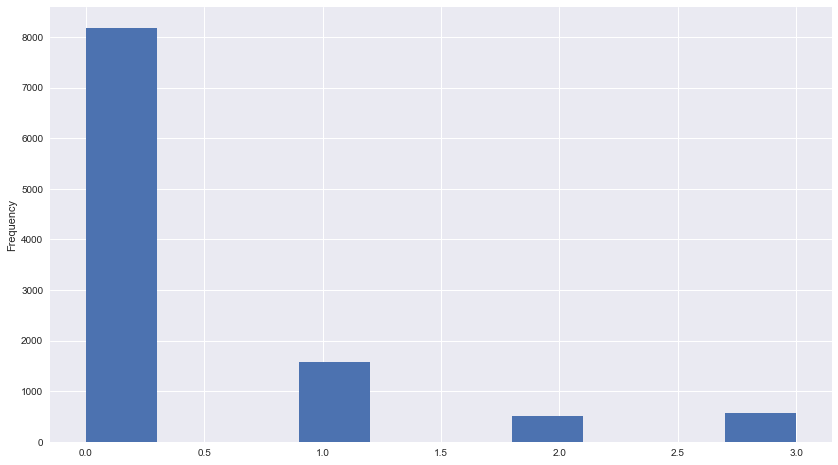

In [10]:
fig = plt.figure(figsize=(14, 8))
#plt.hist(count_table.Num_Pos, bins=np.arange(0, 4, 1))
count_table.Num_Pos.plot(kind='hist')